In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import json

from pathlib import Path
from collections import Counter
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from data_utils import create_documents_from_xml

In [2]:
# root_dir = "documents/RU-DE/special language/press-sociopolitical/WHO/News WHO Europe"
root_dir = "documents"
raw_documents, files = create_documents_from_xml(root_dir)

file_to_save = "data/file_mapping.json"
file_mapping_json = json.dumps(files, ensure_ascii=False)

with open(file_to_save, "w") as f:
    f.write(file_mapping_json)

print(f"Saved file mapping to {file_to_save}: {len(file_mapping_json):,} chars to {os.path.getsize(file_to_save):,} bytes.")
print(f"Total files parsed: {len(files):_}")
print(f"Total documents created: {len(raw_documents):_}")

Saved file mapping to file_mapping.json: 44,769 chars to 53,209 bytes.
Total files parsed: 251
Total documents created: 231_377


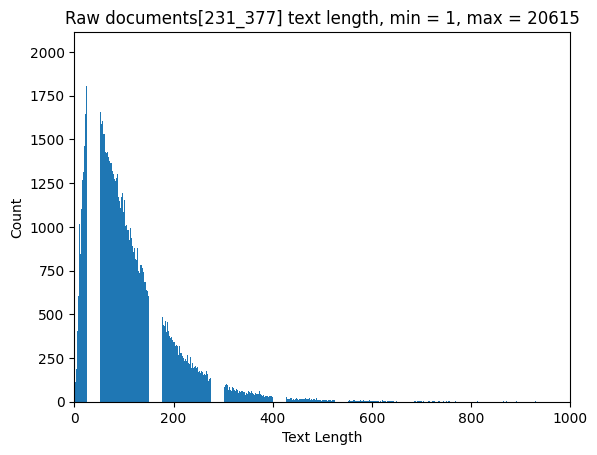

In [3]:
lengths = [len(doc["text"]) for doc in raw_documents]
counter = Counter(lengths)

plt.bar(counter.keys(), counter.values())
plt.xlim(0, 1000)
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.title(f"Raw documents[{len(lengths):_}] text length, min = {min(counter)}, max = {max(counter)}")
plt.show()

In [4]:
# print(random.sample(raw_documents, 1))
print(raw_documents[9])

{'lang': 'de', 'text': 'Clenin öffnete die Wagentür und legte dem Fremden die Hand väterlich auf die Schultern.', 'tr_lang': 'ru', 'tr_text': 'Кленин открыл дверцу машины и по - отечески положил незнакомцу руку на плечо.', 'file_id': 9}


In [5]:
df = pd.DataFrame(raw_documents)
print(f"Converted raw_documents to pandas DataFrame: {len(df):_}")

Converted raw_documents to pandas DataFrame: 231_377


In [6]:
# print(raw_documents[9])
print(df.iloc[9].to_dict())

{'lang': 'de', 'text': 'Clenin öffnete die Wagentür und legte dem Fremden die Hand väterlich auf die Schultern.', 'tr_lang': 'ru', 'tr_text': 'Кленин открыл дверцу машины и по - отечески положил незнакомцу руку на плечо.', 'file_id': 9}


In [7]:
cols = ['text', 'tr_text']
for col in cols:
    df[col] = df[col].str.lower()
print(f"Converted texts to lower case: {len(df):_}")

Converted texts to lower case: 231_377


In [8]:
def get_augmented_data(data_frame):
    copy_df = data_frame.copy()
    temp = copy_df['text']
    copy_df['text'] = copy_df['tr_text']
    copy_df['tr_text'] = temp
    
    temp = copy_df['lang']
    copy_df['lang'] = copy_df['tr_lang']
    copy_df['tr_lang'] = temp
    
    return copy_df

In [9]:
augmented_df = get_augmented_data(df)
print(f"Created augmented df: {len(augmented_df):_}")

Created augmented df: 231_377


In [10]:
df = pd.concat([df, augmented_df], ignore_index=True)
print(f"Concated df and augmented_df: {len(df):_}")

Concated df and augmented_df: 462_754


In [11]:
def get_content_length(text):
    content = "".join(c for c in text if c.isalpha() or c.isspace())
    return len(content)

In [12]:
min_len = 20

filtered_df = df[df['text'].apply(get_content_length) >= min_len]

excluded_df = df[df['text'].apply(get_content_length) < min_len]

print(f"Filtered out small texts from data frame. Left: \
[{len(filtered_df):_} / {len(df):_}], {len(excluded_df)} excluded.")

Filtered out small texts from data frame. Left: [424_358 / 462_754], 38396 excluded.


In [13]:
print(excluded_df.sample(n=1).to_dict(orient='records'))

[{'lang': 'de', 'text': '26. Mai 2017', 'tr_lang': 'ru', 'tr_text': '26 мая 2017', 'file_id': 126537}]


In [22]:
id = 5
print(df.iloc[id].to_dict())
print()
print(augmented_df.iloc[id].to_dict())

{'lang': 'de', 'text': 'Es war ihm nämlich beim Vorbeischreiten gewesen, nachdem er flüchtig durch die trüben Scheiben des Wagens geblickt hatte, als sei der Fahrer auf das Steuer niedergesunken.', 'tr_lang': 'ru', 'tr_text': 'Дело в том, что, когда он проходил мимо и мельком глянул сквозь мутные стекла машины, ему показалось, что водитель навалился на руль.', 'file_id': 5}

{'lang': 'ru', 'text': 'Дело в том, что, когда он проходил мимо и мельком глянул сквозь мутные стекла машины, ему показалось, что водитель навалился на руль.', 'tr_lang': 'de', 'tr_text': 'Es war ihm nämlich beim Vorbeischreiten gewesen, nachdem er flüchtig durch die trüben Scheiben des Wagens geblickt hatte, als sei der Fahrer auf das Steuer niedergesunken.', 'file_id': 5}


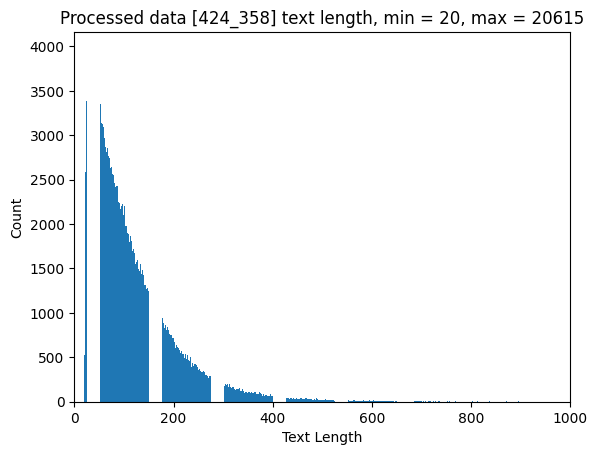

In [15]:
lengths = [len(row["text"]) for _, row in filtered_df.iterrows()]
counter = Counter(lengths)

plt.bar(counter.keys(), counter.values())
plt.xlim(0, 1000)
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.title(f"Processed data [{len(lengths):_}] text length, min = {min(counter)}, max = {max(counter)}")
plt.show()

# Convert documents to langchain Document format

In [16]:
db_documents = [
    Document(
        page_content=doc_item["text"], 
        metadata={
            "lang": doc_item["lang"],
            "tr_lang": doc_item["tr_lang"],
            "tr_text": doc_item["tr_text"],
            "file_id": doc_item["file_id"]
        }) for _, doc_item in filtered_df.iterrows()]
print(f"Converted documents[{len(filtered_df):_}] into db format documents[{len(db_documents):_}]")

Converted documents[424_358] into db format documents[424_358]


In [17]:
splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50)
splitted_chunks = splitter.split_documents(db_documents)
print(f"From all {len(db_documents):_} documents {len(splitted_chunks):_} splitted_chunks created.")

From all 424_358 documents 461_508 splitted_chunks created.


In [18]:
min_docs = [doc for doc in splitted_chunks if get_content_length(doc.page_content) < 5]
print(f"Found {len(min_docs)} docs with small page_content.")

for d in min_docs[:10]:
    print(f"***  [{d.page_content}]")
print()

chunks = [chunk for chunk in splitted_chunks if get_content_length(chunk.page_content) > 5]
print(f"Filtered documents after splitting: [{len(chunks):_} / {len(splitted_chunks):_}]")

Found 2 docs with small page_content.
***  [.]
***  [07.02.2019]

Filtered documents after splitting: [461_506 / 461_508]


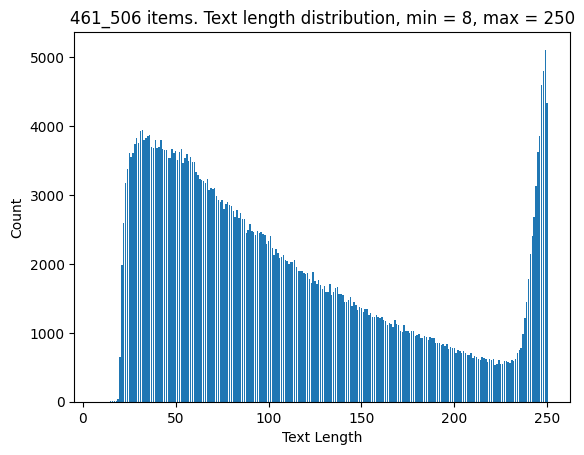

In [19]:
chunk_lengths = [len(chunk.page_content) for chunk in chunks]
chunks_counter = Counter(chunk_lengths)

plt.bar(chunks_counter.keys(), chunks_counter.values())
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.title(f"{len(chunk_lengths):_} items. Text length distribution, min = {min(chunks_counter)}, max = {max(chunks_counter)}")
plt.show()

In [20]:
docs_to_save = [{"page_content": doc.page_content, "metadata": doc.metadata} for doc in chunks]
serialized_docs = json.dumps(docs_to_save, ensure_ascii=False)
print(f"Total characters to save: {len(serialized_docs):,}")
save_path = "data/docs.json"

with open(save_path, "w") as f:
    f.write(serialized_docs)
    print(f"Saved docs to {save_path}: {os.path.getsize(save_path) / 1000 / 1000:_.4f} MB")

Total characters to save: 158,305,074
Saved docs to docs.json: 205.0158 MB


In [21]:
total_size_bytes = 0
directory = Path(root_dir)

file_paths = [f for f in directory.rglob("*") if f.is_file() and not f.name.startswith(".")]

for file_path in file_paths:
    total_size_bytes += os.path.getsize(file_path)

print(f"Total size: {total_size_bytes / 1000 / 1000:_.4f} MB")

Total size: 97.6294 MB
